# Group Assignment Preparation

This tutorial contains various small guides for tasks will come in handy in the upcoming group assignment:

1. Downloading historical weather data with `atlite` from ERA5.
2. Working with representative points in `geopandas` and calculating crow-fly distances.
3. Setting up the Gurobi solver for optimisation problems (optional).

In [ ]:
import atlite
import pypsa
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

## ERA5 Data Download

Suppose you have chosen the Netherlands as your case study region and want to download historical weather data for 1 March 2013 from the ERA5 dataset.

In [ ]:
fn = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-NLD.gpkg"
regions = gpd.read_file(fn)
regions.plot()

You can use the `atlite` package to handle requests to download from the [Copernicus Climate Data Store (CDS)]((https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)) which provides the ERA5 data, so that you **don't** have to manually go through the CDS web interface.

Before you can start, you need to set up an account at the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) and get an **API key**. 

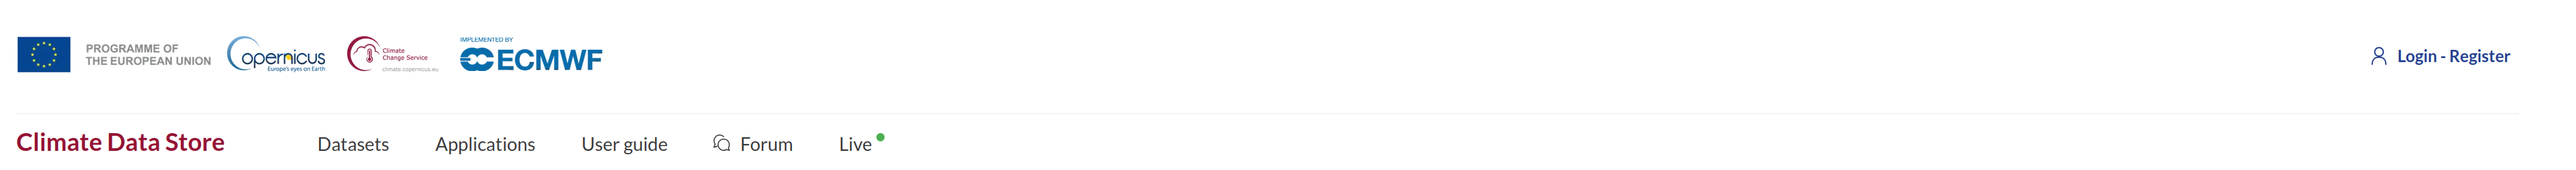

An **API key** is a unique identifier of your account and a way to authenticate users when accessing the CDS programmatically. It is typically stored in a configuration file (i.e., `.cdsapirc` in your home directory for the CDS API).

The setup instructions for the CDS API differ by operating system and can be found on the [CDS API page](https://cds.climate.copernicus.eu/api-how-to). When you are logged in, your personal API key will be shown:

```
url: https://cds.climate.copernicus.eu/api
key: <PERSONAL-ACCESS-TOKEN>
```

:::{note}
If you are using the course environment, the `cdsapi` package is already installed. **You can ignore all instructions about installing the `cdsapi` Python package in the guides.**
:::

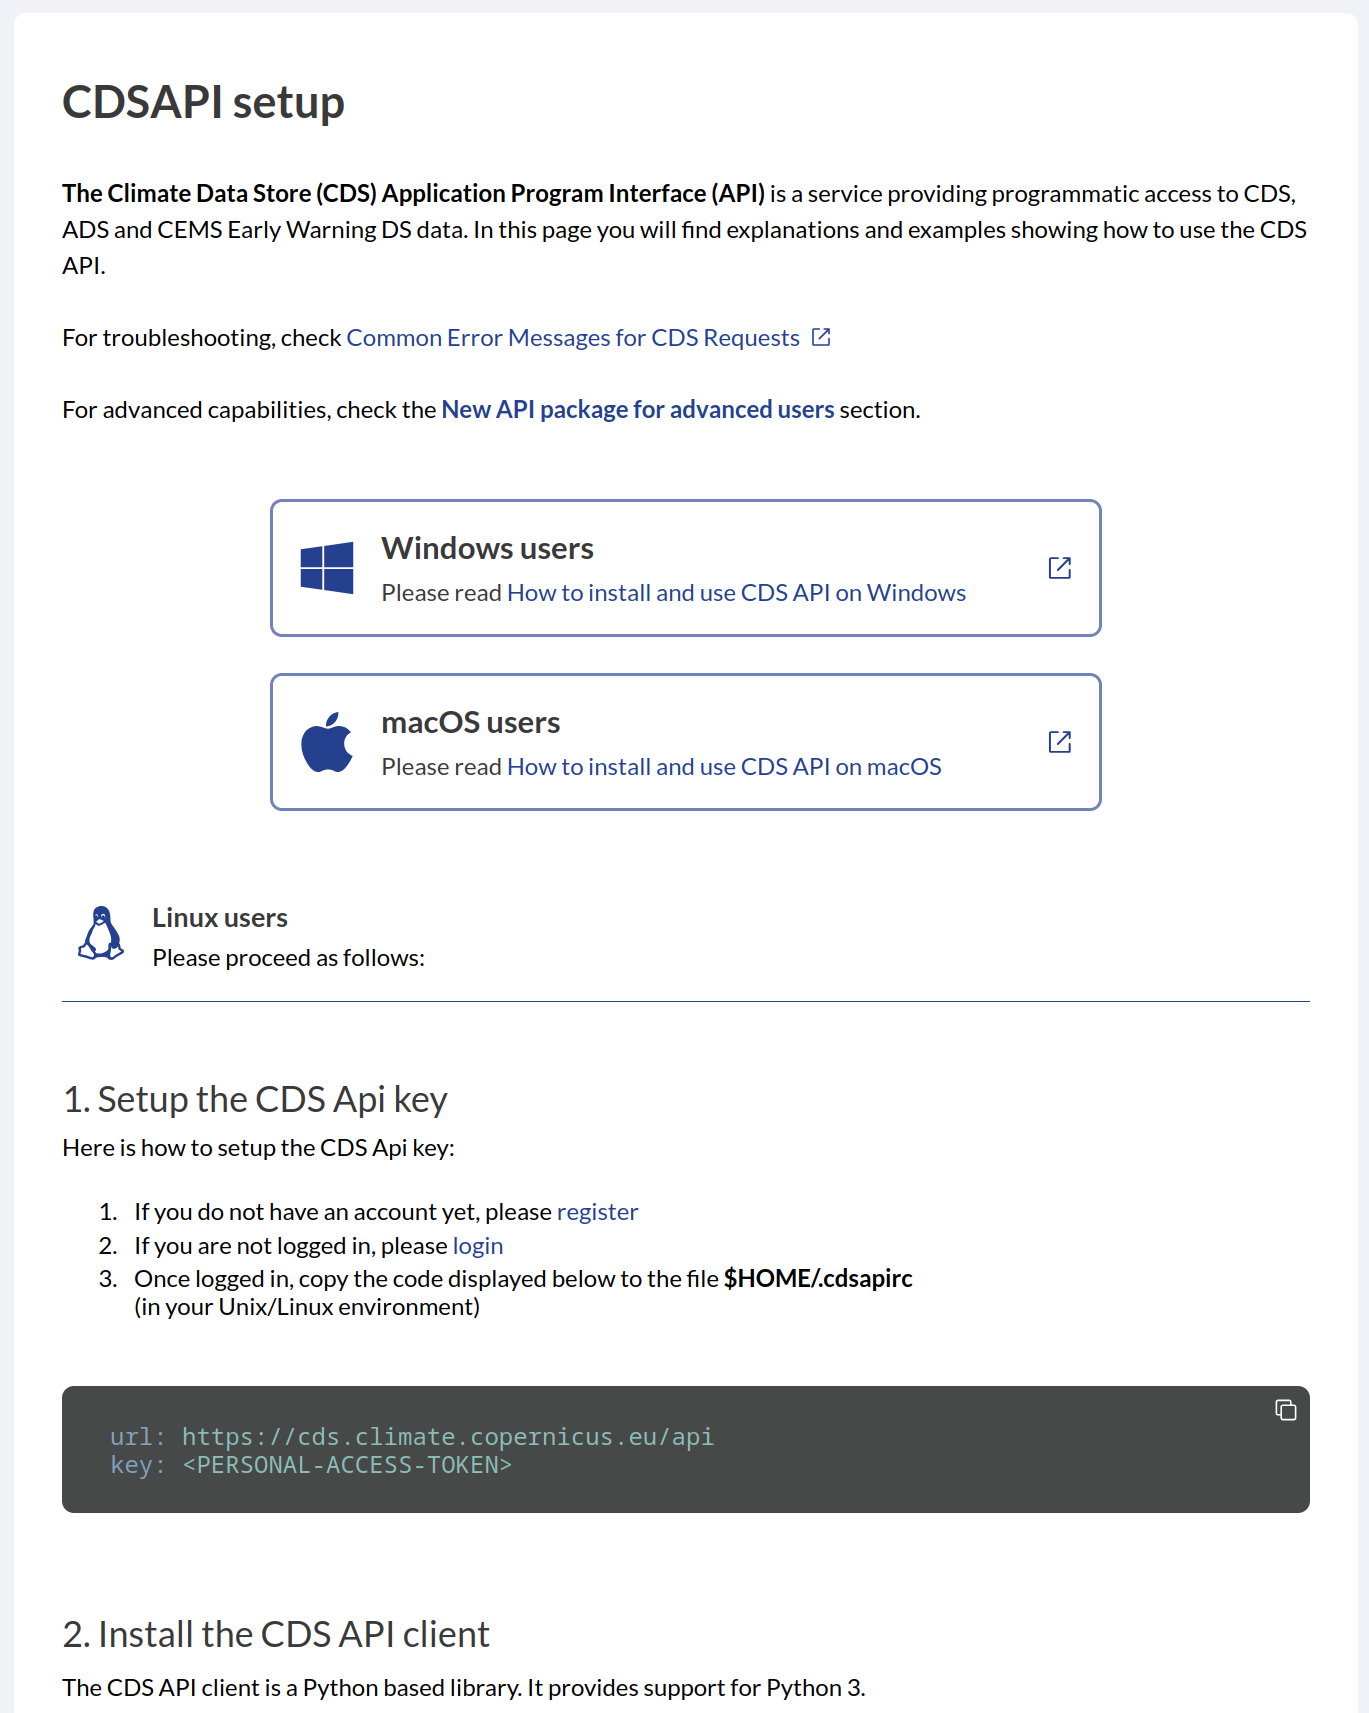

Note that before you can start downloading data, you need to accept the terms of use of the ERA5 dataset [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download) (while logged in). **You do not need to run any API requests from the web interface!** This will be done via `atlite`.

Once you have set up your account and API key, you can start using `atlite` to create a cutout and download the data you need.

Remember that a **cutout** in `atlite` defines the spatial and temporal extent of the weather data you want to work with.

A cutout is **loaded or created** under path provided via the `path` keyword of `atlite.Cutout`; the behaviour varies whether the cutout already exists or not:

1. If a cutout already exists at the path, a call to `atlite.Cutout()` will simply load the cutout again from the hard drive and not try to connect to the CDS API.
2. If the cutout does not yet exist, a call to `atlite.Cutout()` specifies the target file for a **new cutout** to be created by downloading from the CDS API.

For creating a cutout, next to the `path`, you need to specify the dataset `module` (here: ERA5), a time period under `time`, and the spatial extent (in latitude `y` and longitude `x`).

For our example of the Netherlands, we first access the spatial bounds of the country shape and add a 0.25 degree buffer (approximately one grid cell) around it:

In [ ]:
minx, miny, maxx, maxy = regions.total_bounds
buffer = 0.25

cutout = atlite.Cutout(
    path="era5-2013-03-NL.nc",
    module="era5",
    x=slice(minx - buffer, maxx + buffer),
    y=slice(miny - buffer, maxy + buffer),
    time="2013-03-01",
)

Once the cutout is defined, calling the function `cutout.prepare()` initiates the connection to the CDS API, the download and pre-processing of the weather data.
Because the download needs to be provided by the CDS servers, this might take a while depending on the amount of data requested and the length of the queue.

:::{note}
You can check the status of your request [here](https://cds.climate.copernicus.eu/requests?tab=all).
:::

In [ ]:
# cutout.prepare(compression=None)

If we have another cutout prepared (like from the URL below), `atlite` will simply load the cutout from disk instead of downloading it again:

In [ ]:
fn = "era5-2013-NL.nc"
url = "https://tubcloud.tu-berlin.de/s/bAJj9xmN5ZLZQZJ/download/" + fn
urlretrieve(url, fn);

In [ ]:
cutout2 = atlite.Cutout(path=fn)
cutout2

## Global Equal-Area and Equal-Distance CRS

Previously, we used [EPSG:3035](https://epsg.io/3035) as projection to calculate the area of regions in km². However, this projection is not correct for regions outside of Europe, so that we need to pick different, more suitable projections for calculating areas and distances in non-European regions. There are two good options for global projections that preserve either distances or areas:

- **for calculating distances:** [WGS 84 / World Equidistant Cylindrical (EPSG:4087)](https://epsg.io/4087)

- **for calculating areas:** [Mollweide (ESRI:54009)](https://epsg.io/54009)

The unit of measurement for both projections is metres.

In [ ]:
AREA_CRS = "ESRI:54009"
DISTANCE_CRS = "EPSG:4087"

In [ ]:
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)

In [ ]:
world.to_crs(AREA_CRS).plot()

In [ ]:
world.to_crs(DISTANCE_CRS).plot()

## Representative Points and Crow-Fly Distances

The following example includes code to retrieve representative points from polygons and to calculate the distance on a sphere between two points. 
This can be useful when calculating approximate distances for transmission lines between two regions.

:::{note}
See also [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula).

See also [`geopandas.GeoSeries.distance`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html).
:::

In [ ]:
world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)

In [ ]:
points = world.representative_point()

In [ ]:
fig, ax = plt.subplots()
world.plot(ax=ax)
points.plot(ax=ax, color="red", markersize=3);

In [ ]:
points = points.to_crs(4087)
points.index = world.ISO_A3

In [ ]:
distances = pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1).div(
    1e3
)  # km

In [ ]:
distances.loc["DEU", "NLD"]

## Gurobi Solver Setup

[Gurobi](https://www.gurobi.com/) is one of the fastest solvers to solve optimisation problems. 
It is a commercial solver, with free academic licenses.

Using this solver for the group assignment is **optional**. You can also use other open-source alternatives, but they might take longer to solve or do not converge for larger problems.

To set up Gurobi, you need to:

1. Install the Gurobi Python package `gurobipy` inside your environment. Use `pip install gurobipy` or `conda install -c gurobi gurobi` with your environment already activated.

2. Register at [here](https://portal.gurobi.com/iam/register/) with your institutional e-mail address (e.g. `@campus.tu-berlin.de`).

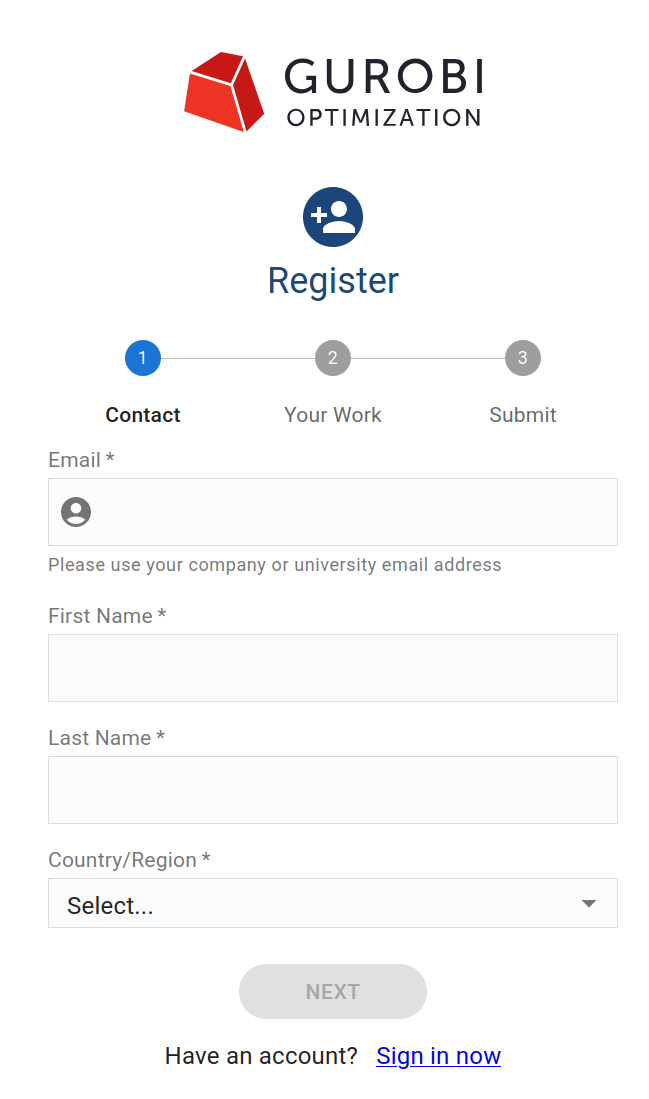

3. Request an academic license [here](https://portal.gurobi.com/iam/licenses/request) (while logged in) from within the university network or via VPN. Choose the *Named-User Academic* license type.

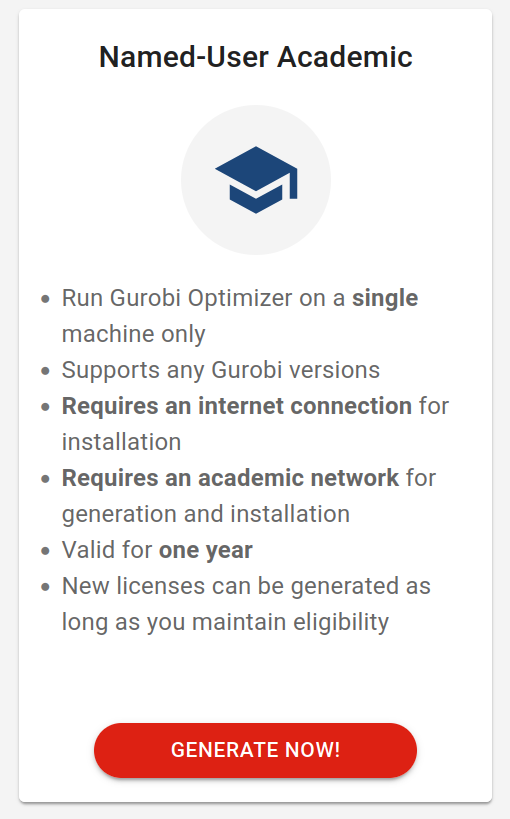

4. You will get pop-up instructions to run a command (e.g., `grbgetkey abcdef-1234-5678-abcd-abcdef123456`) in your terminal to activate the license. Copy and paste this command into your terminal and run it.


:::{note}
If you run into issues, there is a detailed [quickstart guide](https://support.gurobi.com/hc/en-us/articles/14799677517585-Getting-Started-with-Gurobi-Optimizer) to consult.
:::

That should be it! You can now use Gurobi as solver with PyPSA:

In [ ]:
n = pypsa.examples.ac_dc_meshed()
n.optimize(solver_name='gurobi')

On this online website, Gurobi is not installed, so PyPSA will complain with `AssertionError: Solver gurobi not installed`.